In [2]:
import pandas as pd 
df = pd.read_csv("bond_close.csv")

In [3]:
# reorder the rows by the time of Maturity Date
df['Maturity Date'] = pd.to_datetime(df['Maturity Date'])
df = df.sort_values('Maturity Date')
# get the index of the bonds
selected = df[["Coupon", "Issue Date", "Maturity Date"]][df["Maturity Date"].dt.month.isin([3, 9])].index

In [4]:
df = df.loc[selected]
df = df.drop(df.index[-1])
df

,ISIN,Coupon,Issue Date,Maturity Date,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19,2024-01-22
3,CA135087J546,2.250%,10/5/2018,2024-03-01,99.630,99.640,99.650,99.661,99.670,99.687,99.680,99.683,99.708,99.720,99.724
4,CA135087J967,1.500%,4/5/2019,2024-09-01,97.960,97.980,97.985,97.982,98.021,98.054,97.974,97.975,97.999,98.007,98.034
5,CA135087K528,1.250%,10/11/2019,2025-03-01,96.460,96.482,96.552,96.576,96.661,96.715,96.540,96.448,96.495,96.460,96.463
6,CA135087K940,0.500%,4/3/2020,2025-09-01,94.340,94.370,94.380,94.430,94.490,94.490,94.420,94.250,94.240,94.220,94.164
7,CA135087L518,0.250%,10/9/2020,2026-03-01,92.862,92.860,92.844,92.856,93.023,93.008,92.796,92.570,92.546,92.545,92.555
9,CA135087L930,1.000%,4/16/2021,2026-09-01,93.460,93.440,93.550,93.530,93.600,93.570,93.400,93.120,93.080,93.070,93.000
29,CA135087M847,1.250%,10/15/2021,2027-03-01,93.282,93.301,93.245,93.186,93.467,93.493,93.141,92.856,92.753,92.764,92.826
26,CA135087N837,2.750%,5/13/2022,2027-09-01,97.580,97.591,97.603,97.520,97.740,97.772,97.441,97.092,96.956,96.947,96.940
30,CA135087P576,3.500%,10/21/2022,2028-03-01,100.500,100.480,100.439,100.328,100.637,100.673,100.220,99.834,99.662,99.623,99.672
35,CA135087Q491,3.250%,4/21/2023,2028-09-01,99.740,99.720,99.720,99.550,99.880,99.910,99.440,98.990,98.810,98.770,98.830


In [28]:
df.to_csv("bond_close_selected.csv", index=False)

In [5]:
bonds_data = pd.read_csv("bond_close_selected.csv")
bonds_data['Coupon'] = bonds_data['Coupon'].str.rstrip('%').astype('float') 
bonds_data['Issue Date'] = pd.to_datetime(bonds_data['Issue Date'])


from datetime import datetime
# Function to calculate accrued interest
def calculate_accrued_interest(days_since_last_coupon, annual_coupon_rate):
    return (days_since_last_coupon / 365) * annual_coupon_rate

dirty_prices = {isin: {} for isin in bonds_data['ISIN']}
dates = bonds_data.columns[4:]

for _, row1 in bonds_data.iterrows():
    isin = row1['ISIN']
    annual_coupon_rate = row1['Coupon']
    issue_date = row1['Issue Date']
    for date in dates:
        clean_price = row1[date]
        # Calculate the number of days since the last coupon payment
        days_since_last_coupon = (pd.to_datetime(date) - issue_date).days % 365  # Simplistic assumption
        accrued_interest = calculate_accrued_interest(days_since_last_coupon, annual_coupon_rate)
        # Calculate dirty price
        dirty_price = clean_price + accrued_interest
        dirty_prices[isin][date] = dirty_price

# Convert the dirty prices dictionary to a DataFrame for easier manipulation
dirty_prices_df = pd.DataFrame(dirty_prices).T
# drop date columns of bonds_data
bonds_data = bonds_data.drop(dates, axis=1)
# Right Merge the dirty prices DataFrame with the bonds_data DataFrame
bonds_data = pd.merge(bonds_data, dirty_prices_df, left_on='ISIN', right_index=True)
bonds_data['Maturity Date'] = pd.to_datetime(bonds_data['Maturity Date'])
bonds_data.to_csv("bond_close_selected_dirty.csv", index=False)

# Recalculate YTM with the corrected years to maturity
ytm_results_corrected = {isin: {} for isin in bonds_data['ISIN']}

dates = bonds_data.columns[4:]
# Correcting the YTM calculation logic and removing the incorrect inclusion of non-YTM data
for _, row in bonds_data.iterrows():
    F = 100  # Assuming face value of $100
    C = row['Coupon']
    # n = row['Years to Maturity'] 
    maturity_date = row['Maturity Date']
    isin = row['ISIN']
    # for date in dates:
    #     P = row[date]
    #     if n > 0:  # Ensure n is greater than 0 to avoid division by zero
    #         # Recalculating YTM with corrected logic
    #         YTM = ((C + ((F - P) / n)) / ((F + P) / 2)) * 100  # Multiplying by 100 to get a percentage
    #         ytm_results_corrected[isin][date] = YTM
    #     else:
    #         ytm_results_corrected[isin][date] = None  # Set YTM to None if n <= 0
    for date in dates:
        # Calculate the exact time to maturity from the date of the dirty price
        date_obj = pd.to_datetime(date)
        time_to_maturity = (maturity_date - date_obj).days / 365

        # Now we calculate the YTM using the dirty price
        P = dirty_prices_df.at[isin, date]  # Use the dirty price for YTM calculation
        
        if time_to_maturity > 0:
            # YTM calculation using dirty price and exact time to maturity
            YTM = ((C + ((F - P) / time_to_maturity)) / ((F + P) / 2)) * 100  # YTM as a percentage
            ytm_results_corrected[isin][date] = YTM
        else:
            ytm_results_corrected[isin][date] = None

# Removing the incorrect attempt to include Annual Coupon and Years to Maturity in YTM dataframe
# Recreating the DataFrame without those errors
ytm_df_final = pd.DataFrame(ytm_results_corrected).T
ytm_df_final.head()


,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19,2024-01-22
CA135087J546,0.721841,0.579119,0.430825,0.269335,0.116160,-0.303967,-0.353876,-0.488852,-0.816432,-1.046823,-1.510041
CA135087J967,2.888854,2.856909,2.848315,2.852295,2.789643,2.733533,2.861413,2.859068,2.819240,2.805242,2.757545
CA135087K528,4.138889,4.122616,4.062484,4.044145,3.969875,3.930351,4.095442,4.184534,4.144768,4.181274,4.190420
CA135087K940,3.799406,3.784696,3.782824,3.755148,3.720943,3.734451,3.784485,3.899935,3.911295,3.929243,3.980832
CA135087L518,3.678505,3.683539,3.695637,3.693645,3.613462,3.632980,3.744524,3.863726,3.880288,3.885139,3.893098


In [6]:
dirty_prices_df


,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19,2024-01-22
CA135087J546,100.221781,100.237945,100.254110,100.271274,100.286438,100.321932,100.321096,100.330260,100.361425,100.379589,100.402082
CA135087J967,99.106575,99.130685,99.139795,99.140904,99.184014,99.229342,99.153452,99.158562,99.186671,99.198781,99.238110
CA135087K528,96.768219,96.793644,96.867068,96.894493,96.982918,97.047192,96.875616,96.787041,96.837466,96.805890,96.819164
CA135087K940,94.723562,94.754932,94.766301,94.817671,94.879041,94.883151,94.814521,94.645890,94.637260,94.618630,94.566740
CA135087L518,92.924329,92.923014,92.907699,92.920384,93.088068,93.075123,92.863808,92.638493,92.615178,92.614863,92.626918
CA135087L930,94.191507,94.174247,94.286986,94.269726,94.342466,94.320685,94.153425,93.876164,93.838904,93.831644,93.769863
CA135087M847,93.573096,93.595521,93.542945,93.487370,93.771795,93.808068,93.459493,93.177918,93.078342,93.092767,93.165041
CA135087N837,99.388219,99.406753,99.426288,99.350822,99.578356,99.632959,99.309493,98.968027,98.839562,98.838096,98.853699
CA135087P576,101.257534,101.247123,101.215712,101.114301,101.432890,101.497658,101.054247,100.677836,100.515425,100.486014,100.563781
CA135087Q491,102.072877,102.061781,102.070685,101.909589,102.248493,102.305205,101.844110,101.403014,101.231918,101.200822,101.287534


/var/folders/cv/xpstxhmd5h11bv6_3v1994j00000gn/T/ipykernel_49973/2827200777.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Day Progression')


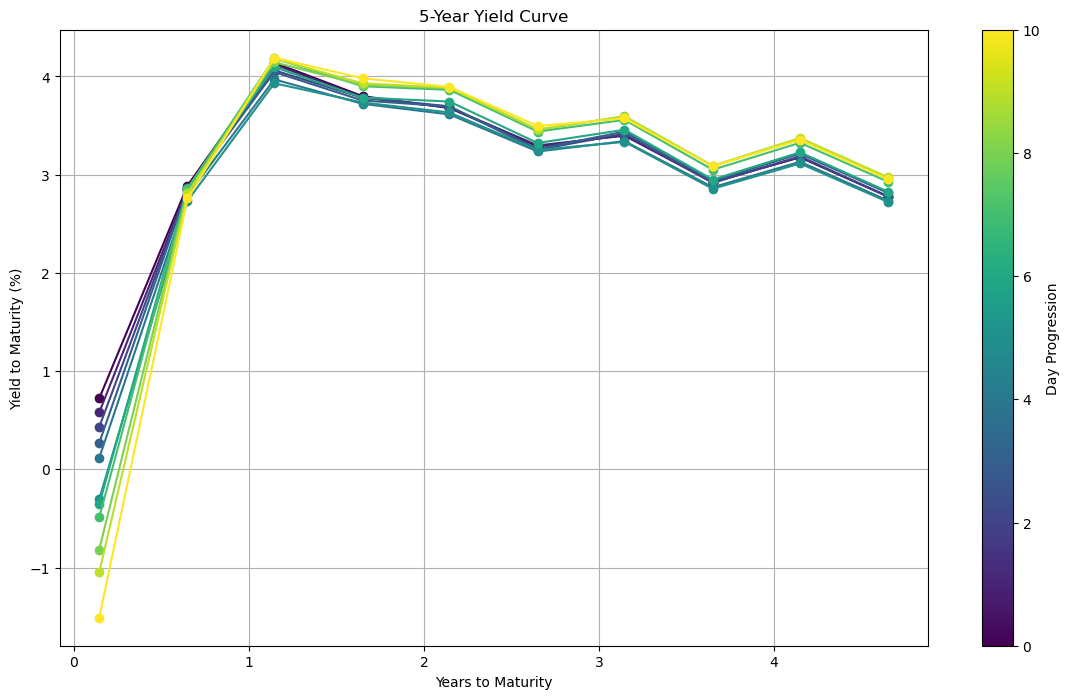

In [7]:
from matplotlib import pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
bonds_data['Years to Maturity'] = (bonds_data['Maturity Date'] - pd.Timestamp(year=2024, month=1, day=8)).dt.days / 365
x_values = bonds_data['Years to Maturity'].unique()  # Unique years to maturity as x-axis values
dates = ytm_df_final.columns  # Dates for which we have YTM values

# Setting up the colormap
norm = Normalize(vmin=0, vmax=len(dates)-1)
colormap = viridis

plt.figure(figsize=(14, 8))

# Plot each day's yield curve with color based on the day's sequence
for i, date in enumerate(dates):
    # Extracting YTM values for the given date for all bonds
    y_values = ytm_df_final[date].values
    # Linear interpolation for plotting
    x_values_sorted, y_values_sorted = zip(*sorted(zip(x_values, y_values)))
    plt.plot(x_values_sorted, y_values_sorted, marker='o', linestyle='-', color=colormap(norm(i)), label=date)

plt.title('5-Year Yield Curve')
plt.xlabel('Years to Maturity')
plt.ylabel('Yield to Maturity (%)')
# Creating a colorbar to represent time progression
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Only needed for matplotlib < 3.1
plt.colorbar(sm, label='Day Progression')
plt.grid(True)
plt.show()


In [9]:
ytm_df_final.to_csv("ytm.csv", index=True)

In [19]:
import numpy as np
ytm_annualized = ytm_df_final.groupby(np.arange(len(ytm_df_final.columns)) // 2, axis=1).mean()
log_returns_ytm = np.log(ytm_annualized / ytm_annualized.shift(1)).dropna()
cov_matrix_ytm = log_returns_ytm.cov()
eigenvalues_ytm, eigenvectors_ytm = np.linalg.eig(cov_matrix_ytm)

print("Covariance Matrix for YTM:")
print(cov_matrix_ytm)
print(f"First Eigenvalue: {eigenvalues_ytm}")
print(f"Associated Eigenvector: {eigenvectors_ytm}")

Covariance Matrix for YTM:
          0         1         2         3         4         5
0  0.028756  0.028542  0.028212  0.029109  0.029911  0.030897
1  0.028542  0.028469  0.028047  0.028958  0.029731  0.030605
2  0.028212  0.028047  0.027777  0.028593  0.029414  0.030414
3  0.029109  0.028958  0.028593  0.029534  0.030343  0.031298
4  0.029911  0.029731  0.029414  0.030343  0.031218  0.032266
5  0.030897  0.030605  0.030414  0.031298  0.032266  0.033493
First Eigenvalue: [1.78833855e-01 3.02592333e-04 5.41866242e-05 4.62056150e-05
 1.32723413e-07 1.01039715e-05]
Associated Eigenvector: [[-0.40066645  0.12997586 -0.83300157  0.28850083  0.18832987  0.09990084]
 [-0.39819058  0.58880595  0.31925791  0.08107269 -0.26403369  0.56261855]
 [-0.39388956 -0.04449455  0.39061242  0.66286475  0.15727052 -0.4755728 ]
 [-0.40616412  0.23517162 -0.10366944 -0.49477716 -0.41073755 -0.59621128]
 [-0.41770553 -0.09206918  0.20047817 -0.47486849  0.73567986  0.10064255]
 [-0.43164159 -0.75541488  0.

/Users/hewitt/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
